In [31]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math

In [32]:
# keep the seed
torch.manual_seed(42)
np.random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [33]:
data = pd.read_csv('./preprocessed_stock_data.csv')
data

,Unnamed: 0,Open,High,Low,Close,Volume,Dividends,Stock Splits,pct_change,log_change,...,7lower,14upper,14lower,21upper,21lower,FT_3components,FT_6components,FT_9components,FT_27components,FT_81components
0,21,0.011564,0.006365,0.022281,0.014347,0.154148,0.0,0.0,0.559269,0.587049,...,0.024512,0.000130,0.026394,0.000298,0.027827,0.388437,0.295708,0.213615,-0.064260,-0.008876
1,22,0.012206,0.005301,0.021376,0.014448,0.235448,0.0,0.0,0.556820,0.584642,...,0.023702,0.000139,0.026372,0.000000,0.027513,0.384802,0.287925,0.203071,-0.066716,-0.016647
2,23,0.013193,0.004814,0.022217,0.013864,0.158318,0.0,0.0,0.548562,0.576516,...,0.023388,0.000260,0.025804,0.000128,0.027124,0.381167,0.280188,0.192697,-0.067142,-0.018242
3,24,0.012770,0.009673,0.023773,0.018108,0.217351,0.0,0.0,0.606749,0.633450,...,0.023249,0.000000,0.025920,0.000095,0.027125,0.377533,0.272499,0.182501,-0.065679,-0.013709
4,25,0.022464,0.017982,0.032964,0.024119,0.303033,0.0,0.0,0.627217,0.653303,...,0.020707,0.002271,0.024916,0.001290,0.026349,0.373899,0.264860,0.172488,-0.062483,-0.003991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1233,1254,0.984652,0.990219,0.986309,0.986920,0.099732,0.0,0.0,0.604866,0.631619,...,0.931125,0.970900,0.994247,0.980050,0.966109,0.481714,0.505675,0.523792,0.665455,0.956588
1234,1255,0.995061,0.987317,0.983119,0.973162,0.106590,0.0,0.0,0.509895,0.538269,...,0.949760,0.975114,1.000000,0.985910,0.970849,0.478211,0.497616,0.511470,0.629582,0.886188
1235,1256,0.990359,0.988684,0.988501,0.987445,0.061586,0.0,0.0,0.603533,0.630322,...,0.964507,0.982731,0.997685,0.991975,0.978107,0.474698,0.489534,0.499109,0.592559,0.795718
1236,1257,0.994921,0.993190,0.991677,0.991759,0.157471,0.0,0.0,0.569920,0.597501,...,0.996039,0.990997,0.997725,0.995947,0.988974,0.471175,0.481432,0.486719,0.554613,0.688859


In [34]:
data['y'] = data['Close']

num_cols = 32

x = data.iloc[:, :num_cols].values
y = data.iloc[:, num_cols].values

split = int(data.shape[0]* 0.8)
train_x, test_x = x[: split, :], x[split:, :]
train_y, test_y = y[: split, ], y[split: , ]

print(f'trainX: {train_x.shape} trainY: {train_y.shape}')
print(f'testX: {test_x.shape} testY: {test_y.shape}')

x_scaler = MinMaxScaler(feature_range = (0, 1))
y_scaler = MinMaxScaler(feature_range = (0, 1))

train_x = x_scaler.fit_transform(train_x)
test_x = x_scaler.transform(test_x)

train_y = y_scaler.fit_transform(train_y.reshape(-1, 1))
test_y = y_scaler.transform(test_y.reshape(-1, 1))

trainX: (990, 32) trainY: (990,)
testX: (248, 32) testY: (248,)


In [35]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dims, latent_dim):
        super().__init__()
        
        # Encoder
        self.encoder_layers = nn.ModuleList()
        current_dim = input_dim
        
        for hidden_dim in hidden_dims:
            self.encoder_layers.append(
                nn.Sequential(
                    nn.Linear(current_dim, hidden_dim),
                    nn.ReLU()
                )
            )
            current_dim = hidden_dim
            
        self.fc_mu = nn.Linear(hidden_dims[-1], latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1], latent_dim)
        
        # Decoder
        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1])
        
        self.decoder_layers = nn.ModuleList()
        reversed_dims = list(reversed(hidden_dims))
        
        for i in range(len(reversed_dims) - 1):
            self.decoder_layers.append(
                nn.Sequential(
                    nn.Linear(reversed_dims[i], reversed_dims[i + 1]),
                    nn.ReLU()
                )
            )
            
        # Final output layer
        self.final_layer = nn.Sequential(
            nn.Linear(reversed_dims[-1], input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        for layer in self.encoder_layers:
            x = layer(x)
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.decoder_input(z)
        for layer in self.decoder_layers:
            x = layer(x)
        return self.final_layer(x)

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), z, mu, log_var

In [36]:
# train_loader = DataLoader(TensorDataset(torch.from_numpy(train_x).float()), batch_size = 128, shuffle = False)
# model = VAE(input_dim=num_cols, hidden_dims=[400, 400, 400,10], latent_dim=10)

model = VAE(input_dim=32,  # Changed for 32 features
           hidden_dims=[484, 832, 1022, 138],  # New optimized dimensions
           latent_dim=36)  # 

train_loader = DataLoader(TensorDataset(torch.from_numpy(train_x).float()), 
                         batch_size=32,  # Changed to optimal batch size
                         shuffle=False)

[1/300] Loss: 85.76981782913208
[2/300] Loss: 71.43655693531036
[3/300] Loss: 61.59777009487152
[4/300] Loss: 56.635000586509705
[5/300] Loss: 53.309587478637695
[6/300] Loss: 47.45269811153412
[7/300] Loss: 41.30924069881439
[8/300] Loss: 37.43854582309723
[9/300] Loss: 34.58018100261688
[10/300] Loss: 31.345857322216034
[11/300] Loss: 28.901359975337982
[12/300] Loss: 27.723224937915802
[13/300] Loss: 26.160123646259308
[14/300] Loss: 24.385379791259766
[15/300] Loss: 23.43697088956833
[16/300] Loss: 22.789455473423004
[17/300] Loss: 22.028426587581635
[18/300] Loss: 21.81825488805771
[19/300] Loss: 22.217521250247955
[20/300] Loss: 22.05949229001999
[21/300] Loss: 21.384298086166382
[22/300] Loss: 21.25598794221878
[23/300] Loss: 21.721838414669037
[24/300] Loss: 22.020323634147644
[25/300] Loss: 21.83877831697464
[26/300] Loss: 21.52621465921402
[27/300] Loss: 21.59773689508438
[28/300] Loss: 21.778601109981537
[29/300] Loss: 21.596345961093903
[30/300] Loss: 21.372261464595795
[31

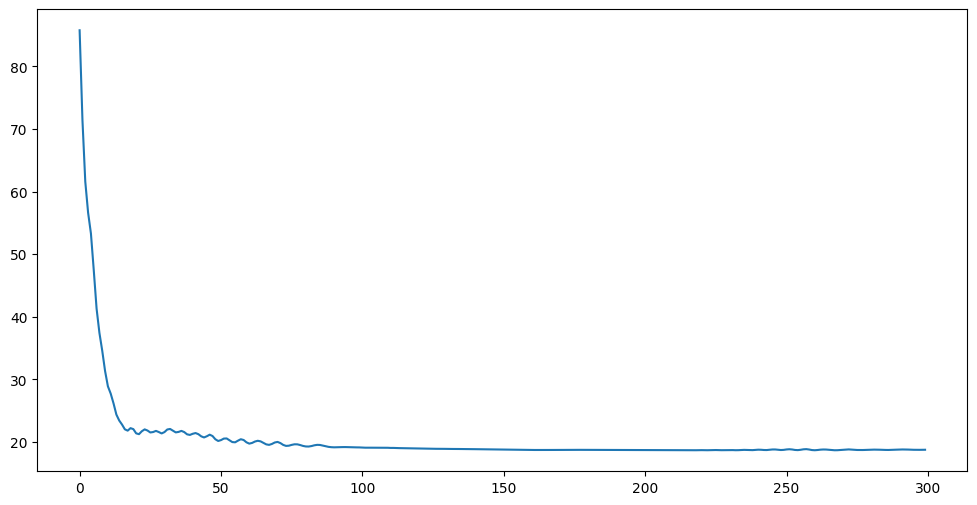

In [37]:
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
num_epochs = 300
learning_rate = 6.536830781589905e-06
model = model.to(device)   
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

hist = np.zeros(num_epochs) 
for epoch in range(num_epochs):
    total_loss = 0
    loss_ = []
    for (x, ) in train_loader:
        x = x.to(device)
        output, z, mu, logVar = model(x)
        kl_divergence = 0.5* torch.sum(-1 - logVar + mu.pow(2) + logVar.exp())
        loss = F.binary_cross_entropy(output, x) + kl_divergence
        loss.backward()
        optimizer.step()
        loss_.append(loss.item())
    hist[epoch] = sum(loss_)
    print('[{}/{}] Loss:'.format(epoch+1, num_epochs), sum(loss_))

plt.figure(figsize=(12, 6))
plt.plot(hist)

In [38]:
model.eval()
_, VAE_train_x, train_x_mu, train_x_var = model(torch.from_numpy(train_x).float().to(device))
_, VAE_test_x, test_x_mu, test_x_var = model(torch.from_numpy(test_x).float().to(device))

In [39]:
# our existing time series window function
def time_series_window(x, y, window_size):
    """
    Args:
        x: Input features array, shape (n_samples, n_features)
        y: Target values array, shape (n_samples, 1)
        window_size: Size of the sliding window
        
    Returns:
        tuple: (
            windowed_x: Feature windows, shape (n_samples-window, window_size, n_features)
            windowed_y: Single target values, shape (n_samples-window, 1)
            windowed_y_gan: Target windows, shape (n_samples-window, window_size+1, 1)
        )
    """
    if not isinstance(x, np.ndarray):
        x = np.array(x)
    if not isinstance(y, np.ndarray):
        y = np.array(y)
        
    n_samples = len(x) - window_size
    
    windowed_x = np.zeros((n_samples, window_size, x.shape[1]))
    windowed_y = np.zeros((n_samples, 1))
    windowed_y_gan = np.zeros((n_samples, window_size + 1, 1))
    
    for i in range(n_samples):
        windowed_x[i] = x[i:i + window_size]
        windowed_y[i] = y[i + window_size]
        windowed_y_gan[i] = y[i:i + window_size + 1]
    
    return (torch.from_numpy(windowed_x).float(),
            torch.from_numpy(windowed_y).float(),
            torch.from_numpy(windowed_y_gan).float())

In [40]:
train_x = np.concatenate((train_x, VAE_train_x.cpu().detach().numpy()), axis = 1)
test_x = np.concatenate((test_x, VAE_test_x.cpu().detach().numpy()), axis = 1)

In [41]:
train_x_slide, train_y_slide, train_y_gan = time_series_window(train_x, train_y, 3)
test_x_slide, test_y_slide, test_y_gan = time_series_window(test_x, test_y, 3)
print(f'train_x: {train_x_slide.shape} train_y: {train_y_slide.shape} train_y_gan: {train_y_gan.shape}')
print(f'test_x: {test_x_slide.shape} test_y: {test_y_slide.shape} test_y_gan: {test_y_gan.shape}')


train_x: torch.Size([987, 3, 68]) train_y: torch.Size([987, 1]) train_y_gan: torch.Size([987, 4, 1])
test_x: torch.Size([245, 3, 68]) test_y: torch.Size([245, 1]) test_y_gan: torch.Size([245, 4, 1])


In [42]:
# GRU + CNN
# class Generator(nn.Module):
#     def __init__(self, input_size):
#         super().__init__()
#         self.gru_1 = nn.GRU(input_size, 1024, batch_first = True)
#         self.gru_2 = nn.GRU(1024, 512, batch_first = True)
#         self.gru_3 = nn.GRU(512, 256, batch_first = True)
#         self.linear_1 = nn.Linear(256, 128)
#         self.linear_2 = nn.Linear(128, 64)
#         self.linear_3 = nn.Linear(64, 1)
#         self.dropout = nn.Dropout(0.2)

#     def forward(self, x):
#         use_cuda = 1
#         device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
#         h0 = torch.zeros(1, x.size(0), 1024).to(device)
#         out_1, _ = self.gru_1(x, h0)
#         out_1 = self.dropout(out_1)
#         h1 = torch.zeros(1, x.size(0), 512).to(device)
#         out_2, _ = self.gru_2(out_1, h1)
#         out_2 = self.dropout(out_2)
#         h2 = torch.zeros(1, x.size(0), 256).to(device)
#         out_3, _ = self.gru_3(out_2, h2)
#         out_3 = self.dropout(out_3)
#         out_4 = self.linear_1(out_3[:, -1, :])
#         out_5 = self.linear_2(out_4)
#         out = self.linear_3(out_5)
#         return out

class Generator(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.gru_1 = nn.GRU(input_size, 652, batch_first=True)  # Changed to 652
        self.gru_2 = nn.GRU(652, 893, batch_first=True)        # Changed to 893
        self.gru_3 = nn.GRU(893, 482, batch_first=True)        # Changed to 482
        self.linear_1 = nn.Linear(482, 164)                    # Changed to 164
        self.linear_2 = nn.Linear(164, 115)                    # Changed to 115
        self.linear_3 = nn.Linear(115, 1)
        self.dropout = nn.Dropout(0.153848576505225)           # New dropout rate

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), 652).to(device)
        out_1, _ = self.gru_1(x, h0)
        out_1 = self.dropout(out_1)

        h1 = torch.zeros(1, x.size(0), 893).to(device)
        out_2, _ = self.gru_2(out_1, h1)
        out_2 = self.dropout(out_2)

        h2 = torch.zeros(1, x.size(0), 482).to(device)
        out_3, _ = self.gru_3(out_2, h2)
        out_3 = self.dropout(out_3)

        out_4 = self.linear_1(out_3[:, -1, :])
        out_5 = self.linear_2(out_4)
        out = self.linear_3(out_5)
        return out

# class Discriminator(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv1d(4, 32, kernel_size = 3, stride = 1, padding = 'same')
#         self.conv2 = nn.Conv1d(32, 64, kernel_size = 3, stride = 1, padding = 'same')
#         self.conv3 = nn.Conv1d(64, 128, kernel_size = 3, stride = 1, padding = 'same')
#         self.linear1 = nn.Linear(128, 220)
#         self.batch1 = nn.BatchNorm1d(220)
#         self.linear2 = nn.Linear(220, 220)
#         self.batch2 = nn.BatchNorm1d(220)
#         self.linear3 = nn.Linear(220, 1)
#         self.leaky = nn.LeakyReLU(0.01)
#         self.relu = nn.ReLU()
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x):
#         conv1 = self.conv1(x)
#         conv1 = self.leaky(conv1)
#         conv2 = self.conv2(conv1)
#         conv2 = self.leaky(conv2)
#         conv3 = self.conv3(conv2)
#         conv3 = self.leaky(conv3)
#         flatten_x = conv3.reshape(conv3.shape[0], conv3.shape[1])
#         out_1 = self.linear1(flatten_x)
#         out_1 = self.leaky(out_1)
#         out_2 = self.linear2(out_1)
#         out_2 = self.relu(out_2)
#         out_3 = self.linear3(out_2)
#         out = self.sigmoid(out_3)
#         return out

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(4, 50, kernel_size=3, stride=1, padding='same')  # 50 filters
        self.conv2 = nn.Conv1d(50, 60, kernel_size=3, stride=1, padding='same') # 60 filters
        self.conv3 = nn.Conv1d(60, 211, kernel_size=3, stride=1, padding='same') # 211 filters
        self.linear1 = nn.Linear(211, 155)  # Changed to 155
        self.linear2 = nn.Linear(155, 155)  # Keep same dimension
        self.linear3 = nn.Linear(155, 1)
        self.leaky = nn.LeakyReLU(0.0666677684638632)  # Optimized slope
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2741225785366103)  # Optimized dropout

    def forward(self, x):
        conv1 = self.conv1(x)
        conv1 = self.leaky(conv1)
        conv2 = self.conv2(conv1)
        conv2 = self.leaky(conv2)
        conv3 = self.conv3(conv2)
        conv3 = self.leaky(conv3)
        flatten_x = conv3.reshape(conv3.shape[0], conv3.shape[1])
        out_1 = self.linear1(flatten_x)
        out_1 = self.leaky(out_1)
        out_2 = self.linear2(out_1)
        out_2 = self.relu(out_2)
        out_3 = self.linear3(out_2)
        return torch.sigmoid(out_3)

In [43]:
# CUDA setup remains the same
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")

# Update batch size to optimized value from tuning
batch_size = 32  # Changed from 128 to match optimal value found by Optuna

# Update learning rates to the optimized values for Generator and Discriminator separately
learning_rate_G = 3.319668704256778e-05  # Optimized Generator learning rate
learning_rate_D = 9.506230598366327e-05  # Optimized Discriminator learning rate

# Keep number of epochs the same as it worked well in your implementation
num_epochs = 165

# Update the DataLoader with new batch size
trainDataloader = DataLoader(TensorDataset(train_x_slide, train_y_gan), 
                           batch_size=batch_size, 
                           shuffle=False)

# Initialize models and send to device
modelG = Generator(num_cols + 36).to(device)  # Note: latent_dim is now 36
modelD = Discriminator().to(device)

# Keep criterion the same
criterion = nn.BCELoss()

# Update optimizers with separate learning rates
optimizerG = torch.optim.Adam(modelG.parameters(), 
                             lr=learning_rate_G, 
                             betas=(0.0, 0.9))
optimizerD = torch.optim.Adam(modelD.parameters(), 
                             lr=learning_rate_D, 
                             betas=(0.0, 0.9))

# Initialize history tracking
histG = np.zeros(num_epochs)
histD = np.zeros(num_epochs)

# Training loop remains largely the same but with smaller batches
for epoch in range(num_epochs):
    loss_G = []
    loss_D = []
    for (x, y) in trainDataloader:
        x = x.to(device)
        y = y.to(device)

        fake_data = modelG(x)
        fake_data = torch.cat([y[:, :3, :], fake_data.reshape(-1, 1, 1)], axis=1)

        dis_real_output = modelD(y)
        real_labels = torch.ones_like(dis_real_output).to(device)
        lossD_real = criterion(dis_real_output, real_labels)

        dis_fake_output = modelD(fake_data)
        fake_labels = torch.zeros_like(real_labels).to(device)
        lossD_fake = criterion(dis_fake_output, fake_labels)

        lossD = (lossD_real + lossD_fake)

        modelD.zero_grad()
        lossD.backward(retain_graph=True)
        optimizerD.step()
        loss_D.append(lossD.item())

        output_fake = modelD(fake_data)
        lossG = criterion(output_fake, real_labels)
        modelG.zero_grad()
        lossG.backward()
        optimizerG.step()
        loss_G.append(lossG.item()) 

    histG[epoch] = sum(loss_G) 
    histD[epoch] = sum(loss_D)    
    print(f'[{epoch+1}/{num_epochs}] LossD: {sum(loss_D)} LossG:{sum(loss_G)}')

[1/165] LossD: 42.966235995292664 LossG:21.764982163906097
[2/165] LossD: 42.979031562805176 LossG:21.505872011184692
[3/165] LossD: 42.97209882736206 LossG:21.486964643001556
[4/165] LossD: 42.971231341362 LossG:21.48745310306549
[5/165] LossD: 42.971423745155334 LossG:21.487931847572327
[6/165] LossD: 42.97255039215088 LossG:21.488106846809387
[7/165] LossD: 42.97311294078827 LossG:21.487720847129822
[8/165] LossD: 42.97364616394043 LossG:21.48825490474701
[9/165] LossD: 42.97318410873413 LossG:21.488308131694794
[10/165] LossD: 42.972988963127136 LossG:21.488250195980072
[11/165] LossD: 42.97259855270386 LossG:21.48868292570114
[12/165] LossD: 42.97208595275879 LossG:21.488794445991516
[13/165] LossD: 42.97189438343048 LossG:21.488431990146637
[14/165] LossD: 42.97182059288025 LossG:21.490179538726807
[15/165] LossD: 42.97085905075073 LossG:21.489575743675232
[16/165] LossD: 42.97002589702606 LossG:21.4895179271698
[17/165] LossD: 42.97074282169342 LossG:21.48949432373047
[18/165] L

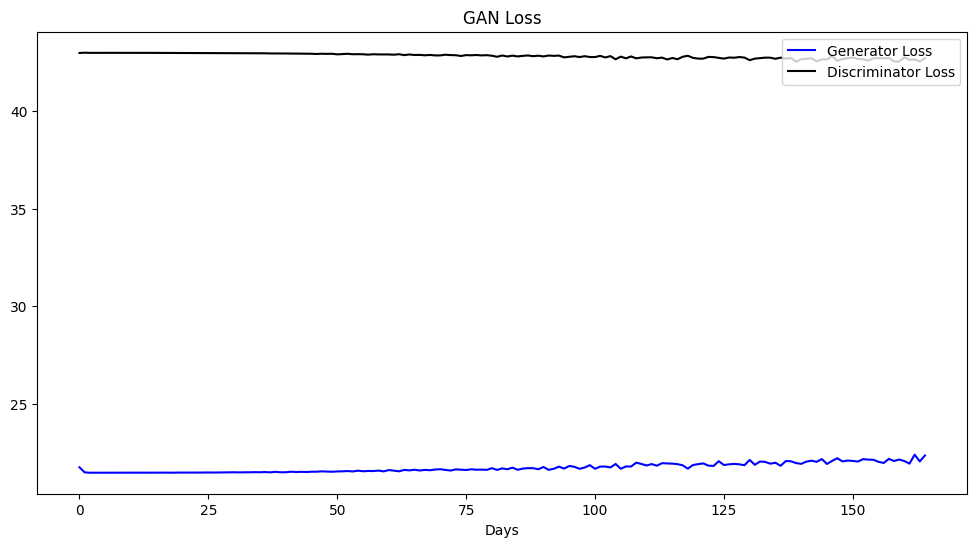

In [44]:
plt.figure(figsize = (12, 6))
plt.plot(histG, color = 'blue', label = 'Generator Loss')
plt.plot(histD, color = 'black', label = 'Discriminator Loss')
plt.title('GAN Loss')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

In [45]:
modelG.eval()
pred_y_train = modelG(train_x_slide.to(device))
pred_y_test = modelG(test_x_slide.to(device))

y_train_true = y_scaler.inverse_transform(train_y_slide)
y_train_pred = y_scaler.inverse_transform(pred_y_train.cpu().detach().numpy())

y_test_true = y_scaler.inverse_transform(test_y_slide)
y_test_pred = y_scaler.inverse_transform(pred_y_test.cpu().detach().numpy())

Training dataset RMSE:0.016299517562713146


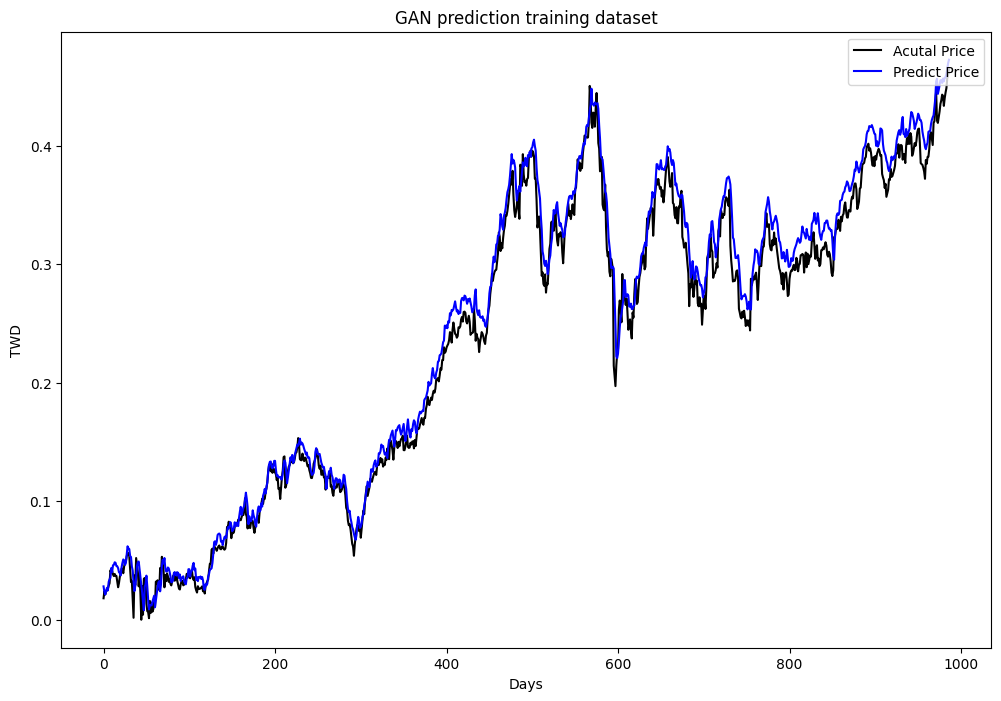

In [46]:
plt.figure(figsize=(12, 8))
plt.plot(y_train_true, color = 'black', label = 'Acutal Price')
plt.plot(y_train_pred, color = 'blue', label = 'Predict Price')
plt.title('GAN prediction training dataset')
plt.ylabel('TWD')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_train_true, y_train_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

Training dataset RMSE:0.07868363482860935


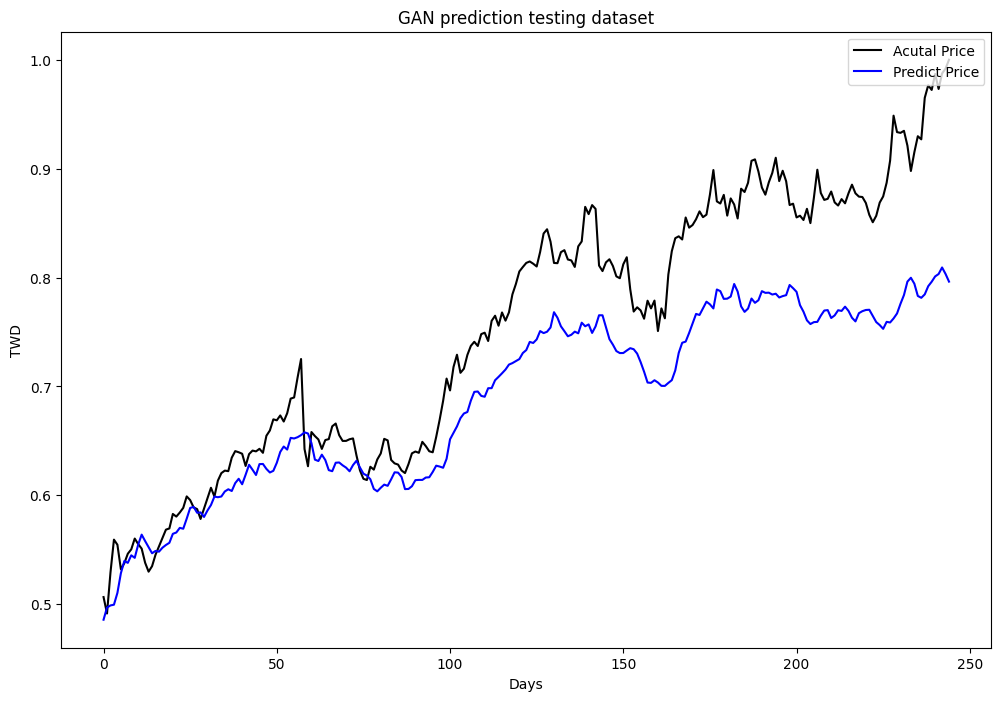

In [47]:
plt.figure(figsize=(12, 8))
plt.plot(y_test_true, color = 'black', label = 'Acutal Price')
plt.plot(y_test_pred, color = 'blue', label = 'Predict Price')
plt.title('GAN prediction testing dataset')
plt.ylabel('TWD')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_test_true, y_test_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')